In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import torch
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as F
from tqdm.notebook import tqdm
import random
from PIL import Image
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [3]:
def ifnone(a,b):
    if a is None:
        return b
    else:
        return a
def transform(input, target,size=(512,1024)):
    input,target = F.resize(input,size),F.resize(target,size)
    a, t, sc, sh = transforms.RandomAffine.get_params(degrees=(0,0),
                                                      translate=(0.1,0.1),
                                                      scale_ranges=(2,2),
                                                      shears=(5,5),
                                                      img_size=size)
    input = F.affine(input, a, t, sc, sh)
    target = F.affine(target, a, t, sc, sh)
    if random.random() > 0.5:
        input = F.hflip(input)
        target = F.hflip(target)
    input,target = F.to_tensor(input), torch.Tensor(np.array(target))
    input = F.normalize(input,imagenet_stats[0],imagenet_stats[1])
    return input, target
def prep_mask(mask):
    return torch.Tensor(mask)
class CityscapesDataset(Dataset):
    def __init__(self,im_path,lab_path,transforms=True,label_func=None):
        self.files = glob.glob(im_path+'/*/*.png')
        self.label_func = lambda x: lab_path+'/'+'/'.join(x.split('/')[-3:])[:-15]+'gtFine_labelIds.png'
        self.label_files = [self.label_func(x) for x in self.files]
        self.transform = transforms
        self.c = 12
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        im = Image.open(self.files[i])
        mask = Image.open(self.label_files[i])
        if self.transform:
            im,mask = transform(im,mask)    
        else:
            im,mask = F.to_tensor(im),torch.tensor(np.array(mask))
            im = F.normalize(im,imagenet_stats[0],imagenet_stats[1])
        return {'im':im,'mask':mask.squeeze()}

In [4]:
train_data = CityscapesDataset('../leftImg8bit/train/','../gtFine')

In [5]:
train_data = CityscapesDataset('../leftImg8bit/train/','../gtFine')
valid_data = CityscapesDataset('../leftImg8bit/val/','../gtFine')
test_data = CityscapesDataset('../leftImg8bit/test/','../gtFine')
train_dl = DataLoader(train_data,batch_size=10,shuffle=True)
valid_dl = DataLoader(valid_data,batch_size=10,shuffle=False)
test_dl = DataLoader(test_data,batch_size=10,shuffle=False)
from linknet_model import Linknet
model = Linknet(34)
class_weights = np.load('cls_wts_34.npy')

In [6]:
len(train_data),len(valid_data),len(test_data)

(2975, 500, 1525)

In [7]:
import matplotlib.pyplot as plt
def dice(inp,targ):
    n = inp.shape[0]
    inp = inp.argmax(dim=1)
    dice = 0
#     Image(torch.abs(inp-targ)).show(figsize=(10,10))
#     diff = torch.abs(inp[0]-targ[0]).cpu().numpy()
#     diff = np.where(diff==0,0,1)
#     plt.figure(figsize=(5,5))
#     plt.imshow(diff,cmap='gray') 
#     plt.show()
    for i in range(n):
        imdice = 0
        for j in torch.unique(targ[i]):
            inpb = torch.where(inp[i]==j,torch.ones_like(inp).cuda(),torch.zeros_like(inp).cuda()).view(-1)
            targb = torch.where(targ[i]==j,torch.ones_like(targ).cuda(),torch.zeros_like(targ).cuda()).view(-1)
            intersection = 2*(inpb*targb).sum()
            union = (inpb+targb).sum()
            class_dice = (intersection/(union + 1e-8))
#             print(class_dice)
            imdice += class_dice
        imdice /= n*torch.unique(targ[i]).shape[0]
        dice += imdice
    return dice

In [8]:
# @TODO: Aug and lr decay. Done
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
model.cuda()
opt = torch.optim.Adam(model.parameters(),lr=5e-4)
# sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=3e-4,div_factor=5,final_div_factor=10000,epochs=80,steps_per_epoch=298,pct_start=0.3)
best_dice = 0
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).cuda())
train_losses,val_losses,dices = [],[],[]
for epoch in tqdm(range(20)):
    model.train()
    for batch in train_dl:
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        loss = loss_fn(ypred,yb.long())
        print(f'{loss:.4f}', end='\r')
        loss.backward()
        opt.step()
        opt.zero_grad()
#         sched.step()
    model.eval()
    d=0
    for i,batch in enumerate(valid_dl):
        ypred = model(batch['im'].cuda())
        yb = batch['mask'].cuda()
        d += dice(ypred.detach(),yb).item()
        vloss = loss_fn(ypred,yb.long())
    d /= i+1
    print(f'Epoch {epoch}: Train Loss: {loss:.4f}, Val Dice: {d:.4f}')
    if d>=best_dice:
        print(f'Better model found at epoch: {epoch}')
        torch.save(model.state_dict(),'best_dice_city.pkl')
        best_dice = d
    train_losses.append(loss.detach().cpu().item())
    val_losses.append(vloss.detach().cpu().item())
    dices.append(d)

Epoch 0: Train Loss: 2.3395, Val Dice: 0.1430
Better model found at epoch: 0
Epoch 1: Train Loss: 1.5684, Val Dice: 0.1842
Better model found at epoch: 1
Epoch 2: Train Loss: 1.3689, Val Dice: 0.2045
Better model found at epoch: 2
Epoch 3: Train Loss: 1.4938, Val Dice: 0.2005
Epoch 4: Train Loss: 1.5956, Val Dice: 0.2146
Better model found at epoch: 4
Epoch 5: Train Loss: 1.3006, Val Dice: 0.2203
Better model found at epoch: 5
Epoch 6: Train Loss: 1.3553, Val Dice: 0.2183
Epoch 7: Train Loss: 1.1647, Val Dice: 0.2167
Epoch 8: Train Loss: 1.3982, Val Dice: 0.2314
Better model found at epoch: 8
Epoch 9: Train Loss: 1.6246, Val Dice: 0.2325
Better model found at epoch: 9
Epoch 10: Train Loss: 1.3569, Val Dice: 0.2265
Epoch 11: Train Loss: 1.0321, Val Dice: 0.2342
Better model found at epoch: 11
Epoch 12: Train Loss: 1.1063, Val Dice: 0.2378
Better model found at epoch: 12
Epoch 13: Train Loss: 0.9986, Val Dice: 0.2418
Better model found at epoch: 13
Epoch 14: Train Loss: 1.0038, Val Dice:

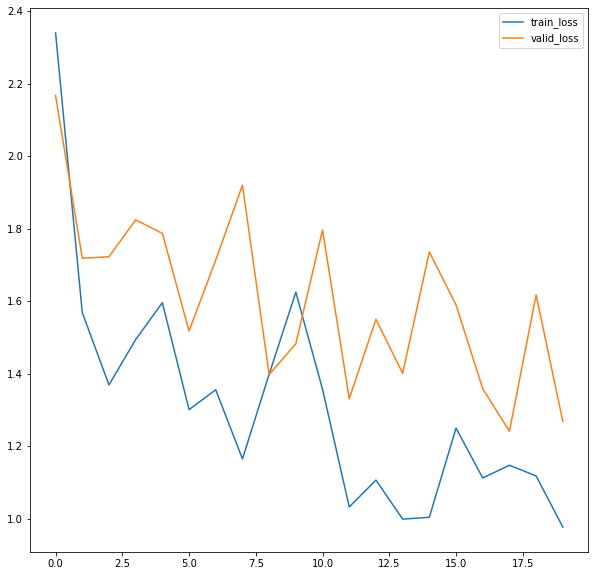

In [9]:
fig = plt.figure(figsize=(10,10))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train_loss','valid_loss'])

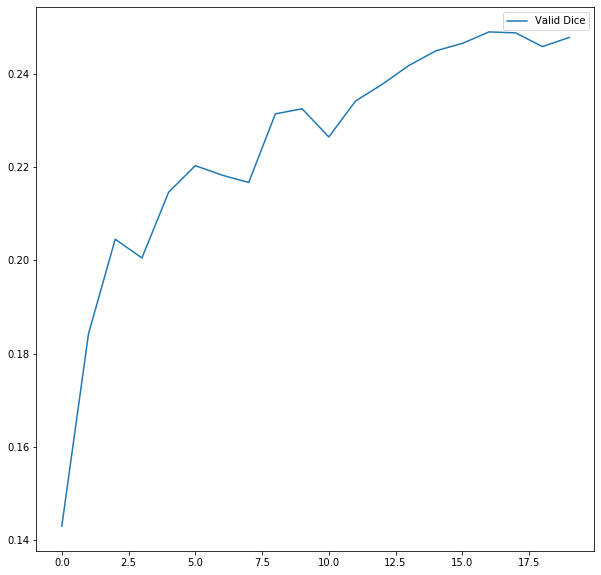

In [10]:
plt.close('all')
fig = plt.figure(figsize=(10,10))
plt.plot(dices)
plt.legend(['Valid Dice'])

In [11]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>